# Lab 7: Recurrent Network Architectures

##### Team: Miro Ronac, Kirk Watson, Brandon Vincitore

##### Dataset Source: https://www.kaggle.com/datasets/yash612/stockmarket-sentiment-dataset


---
### For this lab, we will be utilizing a dataset containing tweets about stocks to identify the sentiment of a tweet. Traders can use this classifier to identify the sentiment of the stock market or a stock by evaulating relevant tweets.
---

In [1]:
%%time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

CPU times: total: 891 ms
Wall time: 959 ms


---
# 1. Preparation
---
## Pre-Processing
---

<IPython.core.display.Javascript object>


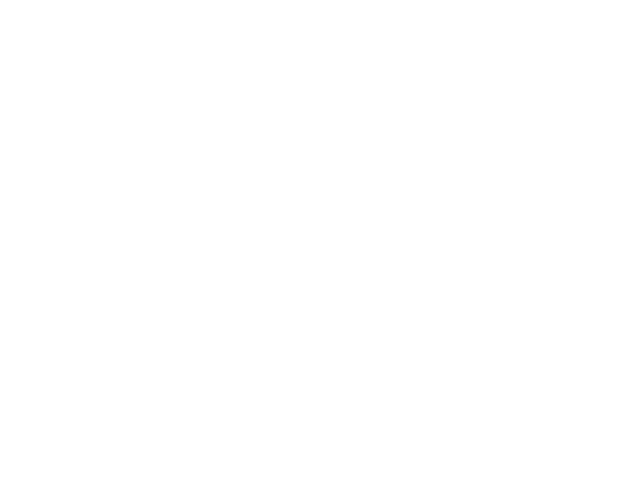

,Tweet,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,Positive
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,Positive
2,user I'd be afraid to short AMZN - they are lo...,Positive
3,MNTA Over 12.00,Positive
4,OI Over 21.37,Positive


In [2]:
%matplotlib notebook

df = pd.read_csv('stock_data.csv')
df = df.rename(columns={'Text': 'Tweet'})

# Drop missing rows
df.dropna(axis=0, inplace=True)

# Checking number of instances in classes
df['Sentiment'] = df['Sentiment'].map({-1:'Negative', 1:'Positive'})
df.groupby('Sentiment').count().plot(kind='bar', rot=0)
plt.ylabel('Instances'); plt.title('Class Distribution')

df.head()

---
##### With the above plot, we see that we are dealing with a slight class imbalance. Let's see the lengths of each text to get an idea of how we should truncate and pad each input sequence.
---

<IPython.core.display.Javascript object>


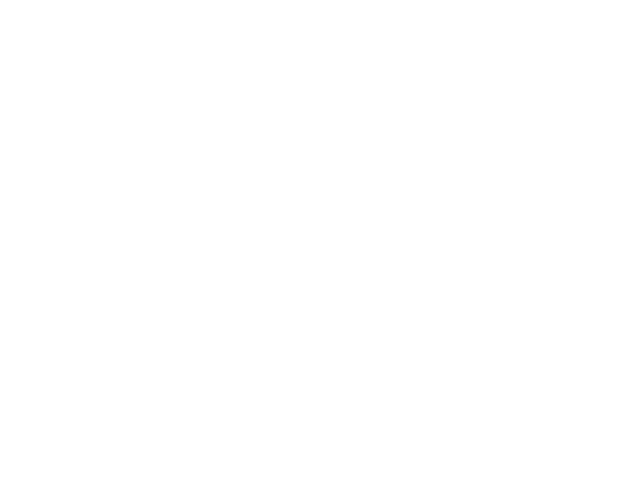

In [3]:
%matplotlib notebook

df['Tweet_Length'] = df.Tweet.str.split().apply(len) # making a column to store text lengths of each input
df.boxplot(column='Tweet_Length')
plt.ylabel('Length'); plt.title('Variance in the Length of Tweets')

df.drop(['Tweet_Length'], axis=1, inplace=True)

---
##### The boxplot above shows that the maximum length of input sequences is capped at 32. The short lengths are expected given the fact that our dataset consists of tweets instead of full blown text documents. We will pad so that all input sequences match the max length of 32. But first, we need a strategy to tokenize each tweet into separate words and from there make sure we extract the most pertinent words to use as input into our model. We will initiate word tokenization and store each token (i.e., keep all words). We decided to do this because, given the fact that our dataset consists of tweets, we believe that we will have words misspelled and/or abbreviated differently as a function of user. By putting a cap on the number of top words, we worry that we will be storing too many repeated words that mean the same but were spelled and/or abbreviated differently while filtering out other unique vocab.
---

In [4]:
#adapted from in-class example notebook

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df.Tweet
y = df.Sentiment

NUM_TOP_WORDS = None # use entire vocabulary!
MAX_TWEET_LEN = 32 # maximum possible words

#tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(X)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(X)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences, maxlen=MAX_TWEET_LEN)

#one hot encode
y[y == "Positive"] = 1
y[y == "Negative"] = 0
y_ohe = keras.utils.to_categorical(y.to_numpy().astype('int64'))

print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 10187 unique tokens. Distilled to 10187 top words.
Shape of data tensor: (5791, 32)
Shape of label tensor: (5791, 2)
10187


---
##### After tokenizing and saving every unique word, we see that 10187 tokens were found. We set the maximum tweet word length to 32 words to account for the largest tweets in the dataset. For our final dataset, we converted each word to an integer and saved each tweet as a series of integers that represent the correct ordering of words. In addition, the target is one hot encoded for positive and negative tweets.
---

---
## Evaluation Metric
---
##### We chose to use the F1-score metric to account for the false negatives (recall) and false positives (precision) when evaulating our unbalanced dataset. In the world of stock trading, understanding the sentiment of the market or a stock is important when evaluating a possible trade. We wouldn't want to wrongly evaluate tweets as negative and cause a trader to possibly miss a good buy. In addition, we wouldn't want to wrongly identify tweets as positive causing a trader to make a miscalculated trade. With the F1-score, we have a better metric to minimize both false ocurrences. Furthermore, our dataset is unbalanced in favor of positive tweets. The F1-score suits unbalanced datasets because it is calculated as a harmonic mean of precision and recall.
---

In [5]:
import tensorflow as tf
from tensorflow.keras import backend as K

# F1-score is no longer supported in keras so we must make a F1-score function
# From https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d

def f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

---
## Divide data into training and testing
---
##### To divide our data into training and testing sets, we will use Stratified Shuffle Split. We chose this method because we need to account for the imbalance of negative and positive tweets. We will only use 1 split due time constraints, and we believe that the dataset is large enough to allow for the model to fit without needing multiple folds. The data will be divided into a 80/20 split to give the model plenty of data to train while still having a sufficient amount of data for testing.
---

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y_ohe):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_ohe[train_index], y_ohe[test_index]
    
print("Training set size:",X_train.shape[0])
print("Testing set size:",X_test.shape[0])

Training set size: 4632
Testing set size: 1159


---
# 2. Modeling
---
## Load embedding: for the embedding we will use a pre-trained Twitter embedding from GloVe
---

In [7]:
!ls -a "GloVe_Twitter/" 

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [8]:
%%time
# From notebook
EMBED_SIZE = 200
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('GloVe_Twitter/glove.twitter.27B.200d.txt', encoding='utf8')

# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
found_words = 0
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be ALL-ZEROS
        embedding_matrix[i] = embedding_vector
        found_words = found_words+1

print("Embedding Shape:",embedding_matrix.shape, "\n",
      "Total words found:",found_words, "\n",
      "Percentage:",100*found_words/embedding_matrix.shape[0])

Found 1193514 word vectors.
Embedding Shape: (10188, 200) 
 Total words found: 7227 
 Percentage: 70.93639575971731
CPU times: total: 40 s
Wall time: 40 s


In [9]:
from tensorflow.keras.layers import Embedding

# Saving embedding
embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],# here is the embedding getting saved
                            input_length=MAX_TWEET_LEN,
                            trainable=False)

---
## Model 1: LSTM
---

In [10]:
# from notebook

def plot_results(history):
    # combine all the history from training together
    combined = dict()
    for key in ['f1','val_f1','loss','val_loss']:
        combined[key] = np.hstack([x.history[key] for x in history])

    # summarize history for accuracy
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(combined['f1'])
    plt.plot(combined['val_f1'])
    plt.title('model f1')
    plt.ylabel('f1')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(combined['loss'])
    plt.plot(combined['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [11]:
# Using Adam optimizer from last lab
#------------------------------------------------------------#
from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.001, epsilon=1e-8)
#------------------------------------------------------------#
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU

NUM_CLASSES = 2

---
##### We will start with a very basic LSTM model..
---

In [12]:
# adapted from notebook

rnn1 = Sequential()

rnn1.add(embedding_layer)
rnn1.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
rnn1.add(Dense(NUM_CLASSES, activation='sigmoid'))

rnn1.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=[f1])

print(rnn1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           2037600   
                                                                 
 lstm (LSTM)                 (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 2,158,202
Trainable params: 120,602
Non-trainable params: 2,037,600
_________________________________________________________________
None


In [13]:
history1 = []
tmp = rnn1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)
history1.append(tmp)

Epoch 1/20
73/73 [==============================] - 8s 79ms/step - loss: 0.6374 - f1: 0.6556 - val_loss: 0.6009 - val_f1: 0.6741
Epoch 2/20
73/73 [==============================] - 6s 76ms/step - loss: 0.5630 - f1: 0.7080 - val_loss: 0.5772 - val_f1: 0.6929
Epoch 3/20
73/73 [==============================] - 6s 77ms/step - loss: 0.5212 - f1: 0.7448 - val_loss: 0.5461 - val_f1: 0.7012
Epoch 4/20
73/73 [==============================] - 6s 76ms/step - loss: 0.4948 - f1: 0.7575 - val_loss: 0.5329 - val_f1: 0.7171
Epoch 5/20
73/73 [==============================] - 5s 75ms/step - loss: 0.4765 - f1: 0.7713 - val_loss: 0.5310 - val_f1: 0.7172
Epoch 6/20
73/73 [==============================] - 6s 76ms/step - loss: 0.4399 - f1: 0.7935 - val_loss: 0.5175 - val_f1: 0.7346
Epoch 7/20
73/73 [==============================] - 6s 76ms/step - loss: 0.3958 - f1: 0.8224 - val_loss: 0.5282 - val_f1: 0.7399
Epoch 8/20
73/73 [==============================] - 6s 76ms/step - loss: 0.3681 - f1: 0.8369 - va

<IPython.core.display.Javascript object>


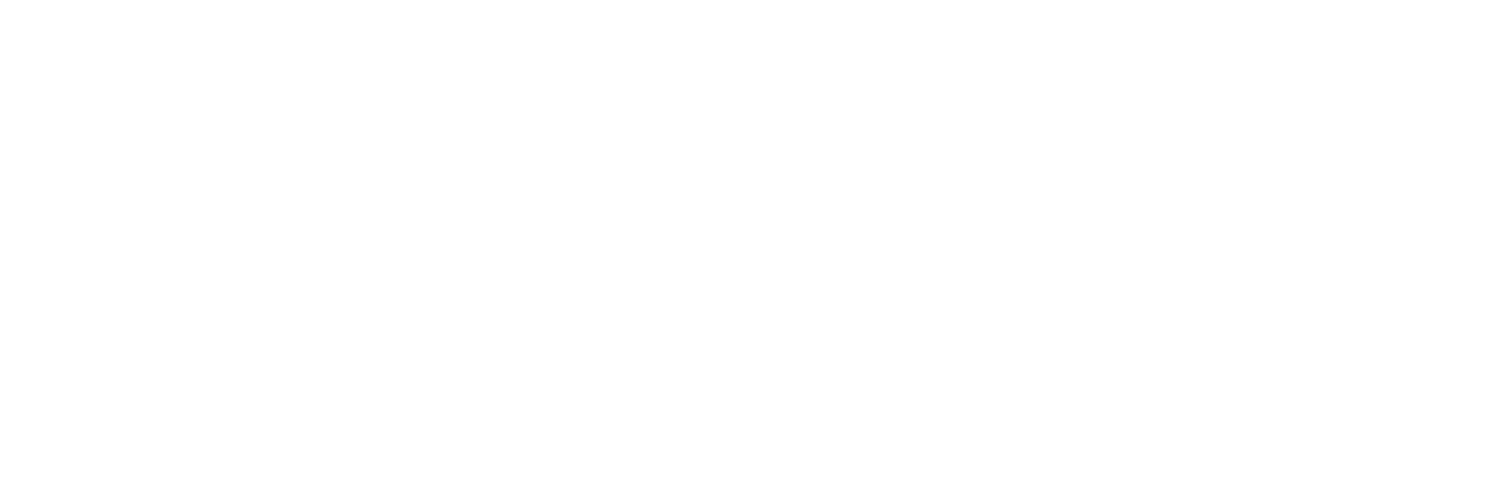

In [14]:
%matplotlib notebook
plot_results(history1)

---
##### It looks like we are dealing with an overfitting problem. Let's reduce the number of units in our LSTM, add L1/L2 regularization, and increase dropout. As a result, we expect a drop in the overall performance of our model, so far that reason let's add another LSTM layer. Moreover, we are suspicious that our model might be getting stuck at local minima. Therefore, in order to mitigate this issue, we want to decay the learning rate of our optimizer. Instead of tuning our adam optimizer, we will instead increase the batch size [Smith et al., 2018]. We will also increase the number of epochs because it doesn't appear that we saw convergence with the test validation loss.
---

In [15]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1L2

regularizers = [L1L2(l1=0.0, l2=0.0), L1L2(l1=0.01, l2=0.0), L1L2(l1=0.0, l2=0.01), L1L2(l1=0.01, l2=0.01)]

In [16]:
rnn2 = Sequential()

rnn2.add(embedding_layer)

rnn2.add(LSTM(50, dropout=0.3, recurrent_dropout=0.2, bias_regularizer=regularizers[3], return_sequences=True))
rnn2.add(LSTM(25, dropout=0.2, recurrent_dropout=0.2, bias_regularizer=regularizers[3]))

rnn2.add(Dense(NUM_CLASSES, activation='sigmoid'))

rnn2.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=[f1])
print(rnn2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           2037600   
                                                                 
 lstm_1 (LSTM)               (None, 32, 50)            50200     
                                                                 
 lstm_2 (LSTM)               (None, 25)                7600      
                                                                 
 dense_1 (Dense)             (None, 2)                 52        
                                                                 
Total params: 2,095,452
Trainable params: 57,852
Non-trainable params: 2,037,600
_________________________________________________________________
None


In [17]:
history2 = []
# increase epochs
tmp = rnn2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=256)
history2.append(tmp)

Epoch 1/30
19/19 [==============================] - 7s 179ms/step - loss: 2.0552 - f1: 0.6683 - val_loss: 1.9040 - val_f1: 0.6734
Epoch 2/30
19/19 [==============================] - 3s 146ms/step - loss: 1.7820 - f1: 0.6952 - val_loss: 1.6687 - val_f1: 0.6751
Epoch 3/30
19/19 [==============================] - 3s 147ms/step - loss: 1.5701 - f1: 0.7352 - val_loss: 1.5123 - val_f1: 0.7083
Epoch 4/30
19/19 [==============================] - 3s 149ms/step - loss: 1.4168 - f1: 0.7575 - val_loss: 1.3941 - val_f1: 0.7292
Epoch 5/30
19/19 [==============================] - 3s 148ms/step - loss: 1.2921 - f1: 0.7681 - val_loss: 1.2823 - val_f1: 0.7316
Epoch 6/30
19/19 [==============================] - 3s 149ms/step - loss: 1.1766 - f1: 0.7838 - val_loss: 1.1972 - val_f1: 0.7477
Epoch 7/30
19/19 [==============================] - 3s 152ms/step - loss: 1.0894 - f1: 0.7895 - val_loss: 1.1357 - val_f1: 0.7355
Epoch 8/30
19/19 [==============================] - 3s 151ms/step - loss: 0.9966 - f1: 0.8

<IPython.core.display.Javascript object>


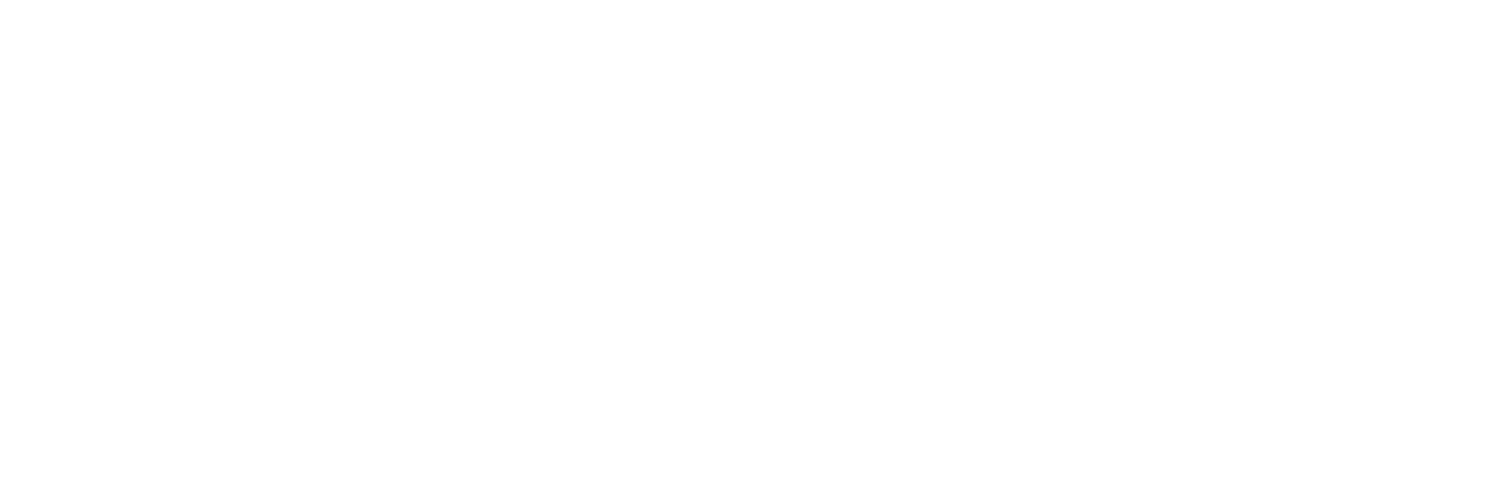

In [18]:
%matplotlib notebook
plot_results(history2)

---
##### Not only have we improved our overfitting, as seen by a decreased test loss towards the final epochs, but we have also slightly increased our test f1 score. Not surprisingly however, we simultaneously decreased our training set f1 score. This is due to the fact that we reduced the number of units in our LSTM and increased our dropout rate. Ultimately though, our goal is to improve our test scores as much as possible since our model's performance against the test set would be most analogous to how it would perform given an "unseen'' input dataset.
---
##### Now let's keep our same parameters and utilize GRU. We will subsequently compare the models.
---

---
## Model 2: GRU
---

In [19]:
rnn3 = Sequential()

rnn3.add(embedding_layer)

rnn3.add(GRU(50, dropout=0.3, recurrent_dropout=0.2, bias_regularizer=regularizers[3], return_sequences=True))
rnn3.add(GRU(25, dropout=0.2, recurrent_dropout=0.2, bias_regularizer=regularizers[3]))

rnn3.add(Dense(NUM_CLASSES, activation='sigmoid'))

rnn3.compile(loss='binary_crossentropy', 
              optimizer=adam, 
              metrics=[f1])
print(rnn3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 200)           2037600   
                                                                 
 gru (GRU)                   (None, 32, 50)            37800     
                                                                 
 gru_1 (GRU)                 (None, 25)                5775      
                                                                 
 dense_2 (Dense)             (None, 2)                 52        
                                                                 
Total params: 2,081,227
Trainable params: 43,627
Non-trainable params: 2,037,600
_________________________________________________________________
None


In [20]:
history3 = []
tmp = rnn3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=256)
history3.append(tmp)

Epoch 1/30
19/19 [==============================] - 6s 159ms/step - loss: 0.6550 - f1: 0.6441 - val_loss: 0.6225 - val_f1: 0.6673
Epoch 2/30
19/19 [==============================] - 2s 128ms/step - loss: 0.5926 - f1: 0.7007 - val_loss: 0.5969 - val_f1: 0.6903
Epoch 3/30
19/19 [==============================] - 2s 129ms/step - loss: 0.5511 - f1: 0.7261 - val_loss: 0.5617 - val_f1: 0.7082
Epoch 4/30
19/19 [==============================] - 2s 131ms/step - loss: 0.5200 - f1: 0.7479 - val_loss: 0.5493 - val_f1: 0.7088
Epoch 5/30
19/19 [==============================] - 3s 132ms/step - loss: 0.4860 - f1: 0.7598 - val_loss: 0.5367 - val_f1: 0.7274
Epoch 6/30
19/19 [==============================] - 3s 132ms/step - loss: 0.4673 - f1: 0.7845 - val_loss: 0.5304 - val_f1: 0.7258
Epoch 7/30
19/19 [==============================] - 2s 132ms/step - loss: 0.4480 - f1: 0.7837 - val_loss: 0.5188 - val_f1: 0.7261
Epoch 8/30
19/19 [==============================] - 3s 132ms/step - loss: 0.4355 - f1: 0.8

<IPython.core.display.Javascript object>


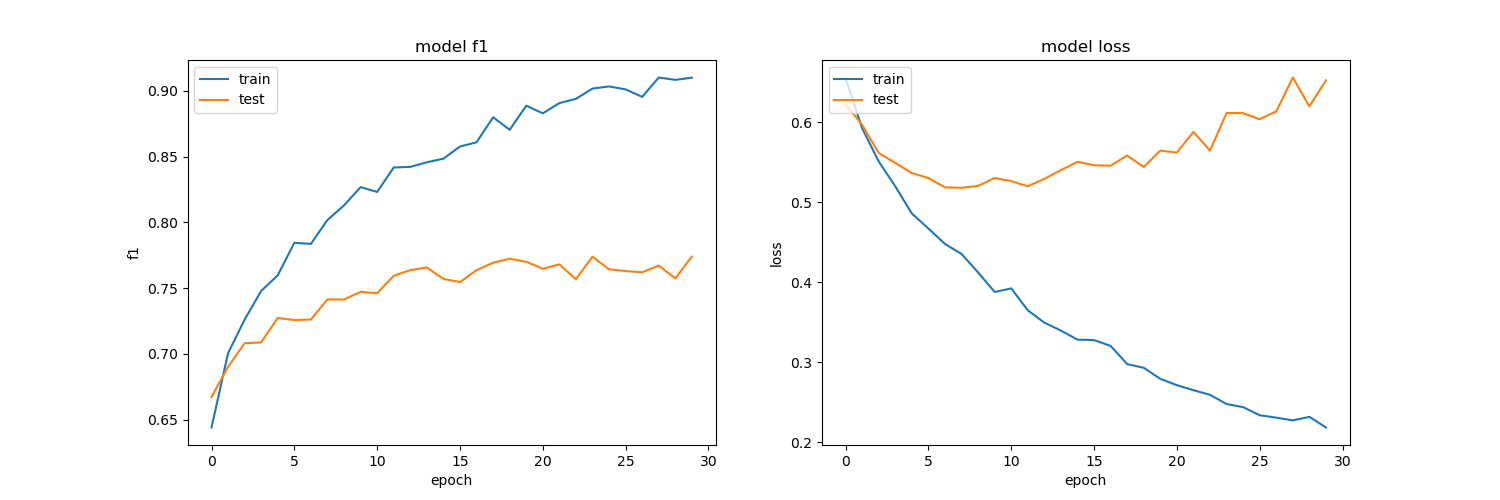

In [21]:
%matplotlib notebook
plot_results(history3)

---
##### It appears as though the GRU model performs similarly to our previous LSTM. The only downside comparatively is that the test model loss looks like it hasn't converged, on the other hand it actually looks like it is beginning to explode, which is not good in terms of model overfitting. We do see a convergence in the test f1 scores. Scores are very similar to our LSTM (might be a tiny bit lower). One clear improvement however, is that GRU runs a bit faster. This is due to the fact that its internal structure isn't as complex as LSTM's.
---
##### Now let's compare the RNN models with a CNN. We will have 2 1D Conv layers with batch normalization and high dropout rates to mitigate for the overfitting we have been dealing with. We will keep batch size and epochs at the same integer values.
---

In [22]:
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout
from keras.models import Model

In [23]:
sequence_input = Input(shape=(MAX_TWEET_LEN,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)

x = Conv1D(128, 1, activation='relu', kernel_initializer='he_uniform')(embedded_sequences)
x = BatchNormalization()(x)
x = MaxPooling1D(2)(x)
x = Dropout(0.5)(x)

x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(12)(x) # global maxpooling
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
preds = Dense(NUM_CLASSES, activation='sigmoid', kernel_initializer='glorot_uniform')(x)

cnn = Model(sequence_input, preds)
cnn.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=[f1])
print(cnn.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32)]              0         
                                                                 
 embedding (Embedding)       (None, 32, 200)           2037600   
                                                                 
 conv1d (Conv1D)             (None, 32, 128)           25728     
                                                                 
 batch_normalization (BatchN  (None, 32, 128)          512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 128)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 128)           0     

In [24]:
history4 = []
tmp = cnn.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=256)
history4.append(tmp)

Epoch 1/30
19/19 [==============================] - 2s 82ms/step - loss: 1.3806 - f1: 0.5401 - val_loss: 0.6952 - val_f1: 0.6566
Epoch 2/30
19/19 [==============================] - 1s 65ms/step - loss: 0.7186 - f1: 0.6162 - val_loss: 0.6548 - val_f1: 0.6198
Epoch 3/30
19/19 [==============================] - 1s 63ms/step - loss: 0.6698 - f1: 0.6292 - val_loss: 0.6514 - val_f1: 0.6725
Epoch 4/30
19/19 [==============================] - 1s 69ms/step - loss: 0.6264 - f1: 0.6731 - val_loss: 0.6348 - val_f1: 0.6682
Epoch 5/30
19/19 [==============================] - 1s 69ms/step - loss: 0.6070 - f1: 0.6704 - val_loss: 0.6242 - val_f1: 0.6754
Epoch 6/30
19/19 [==============================] - 1s 62ms/step - loss: 0.5897 - f1: 0.6986 - val_loss: 0.6045 - val_f1: 0.6940
Epoch 7/30
19/19 [==============================] - 2s 78ms/step - loss: 0.5630 - f1: 0.7021 - val_loss: 0.5816 - val_f1: 0.7081
Epoch 8/30
19/19 [==============================] - 1s 62ms/step - loss: 0.5302 - f1: 0.7268 - va

---
##### Evidently, we see a huge drop in our train f1 scores. Nevertheless, this is our best model in terms of mitigating for overfitting, as seen in the comparatively lower test model loss values (appear to converge at < 0.5). Once again, we see very similar f1 scores compared to our previous GRU and LSTM models. There is a dramatic improvement in runtime, where we have seemingly cut down processing times by half. By just examining the processing time and performance of our model on the test set, we believe this might be our best option. 
---

---
## Comparing Models
---
##### As shown in the corresponding charts for each model, our RNN models struggled with overfitting. The CNN model struggled less with overfitting. For each of the models, the f1-score for the testing set had a similar result.

##### Below, we examine the error rate for each model and find the confidence intervals between selected models.
---

In [25]:
import numpy as np

y_hat1 = np.round(rnn1.predict(X_test))
y_hat2 = np.round(rnn2.predict(X_test))
y_hat3 = np.round(rnn3.predict(X_test))
y_hat4 = np.round(cnn.predict(X_test))

err1 = 1 - f1(y_hat1, y_test)
err2 = 1 - f1(y_hat2, y_test)
err3 = 1 - f1(y_hat3, y_test)
err4 = 1 - f1(y_hat4, y_test)

print()
print('Error rate of LSTM model:', err1.numpy())
print('Error rate of optimized LSTM model:', err2.numpy())
print('Error rate of GRU model:', err3.numpy())
print('Error rate of CNN model', err4.numpy())

def confidence_interval(err1, err2):
    d = np.abs(err1 - err2)
    var = (err2 * (1-err2)/X_test.size) + (err1 * (1-err1)/X_test.size)
    return (d-1.96*np.sqrt(var), d+1.96*np.sqrt(var))

print()
print('Confidence interval for LSTM model and optimized LSTM model:',confidence_interval(err1,err2))
print('Confidence interval for GRU model and CNN model:',confidence_interval(err3,err4))
print()
print('Confidence interval for LSTM model and GRU model:',confidence_interval(err1,err3))
print('Confidence interval for optimized LSTM model and GRU model:',confidence_interval(err2,err4))

37/37 [==============================] - 0s 1ms/step

Error rate of LSTM model: 0.22850978
Error rate of optimized LSTM model: 0.23514223
Error rate of GRU model: 0.22572297
Error rate of CNN model 0.23295951

Confidence interval for LSTM model and optimized LSTM model: (0.0005587680544704198, 0.012706126431003214)
Confidence interval for GRU model and CNN model: (0.0011857734527438877, 0.013287307182326912)

Confidence interval for LSTM model and GRU model: (-0.003243405995890498, 0.008817036328837275)
Confidence interval for optimized LSTM model and GRU model: (-0.003911355854943395, 0.008276800038293005)


---
##### After examining the results above, we see that the confidence interval for the LSTM and GRU model contains 0. As a result, we can determine that these respective models statistically do not have performance differences.

##### When observing the error rates, we can see that the GRU model had the smallest error rate but the differences between each model is minimal.
---